# <h1 style='background:#30D5C8; border:0; color:white'><center>🐟🐠Sea Animals Image Classification</center></h1>

# **<span style="color:#2E8B57;">📰About the Dataset</span>**

In this dataset, there are 19 different classes available and may be extended further in the future. The images are resized to either (300px, n) or (n,300px) where n is a pixel size less than 300px.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Environment check
import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# **<span style="color:#2E8B57;">📰Get Data and apply some augmentation</span>**

In [8]:
data = "/content/drive/MyDrive/Трубчик МО/Рыбки"

In [9]:
image_dir = Path(data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [10]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("/content/drive/MyDrive/Трубчик МО/Рыбки").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [11]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/Трубчик МО/Рыбки/Clams/...,Clams
1,/content/drive/MyDrive/Трубчик МО/Рыбки/Clams/...,Clams
2,/content/drive/MyDrive/Трубчик МО/Рыбки/Clams/...,Clams
3,/content/drive/MyDrive/Трубчик МО/Рыбки/Clams/...,Clams
4,/content/drive/MyDrive/Трубчик МО/Рыбки/Clams/...,Clams
...,...,...
1773,/content/drive/MyDrive/Трубчик МО/Рыбки/Dolphi...,Dolphin
1774,/content/drive/MyDrive/Трубчик МО/Рыбки/Dolphi...,Dolphin
1775,/content/drive/MyDrive/Трубчик МО/Рыбки/Dolphi...,Dolphin
1776,/content/drive/MyDrive/Трубчик МО/Рыбки/Dolphi...,Dolphin


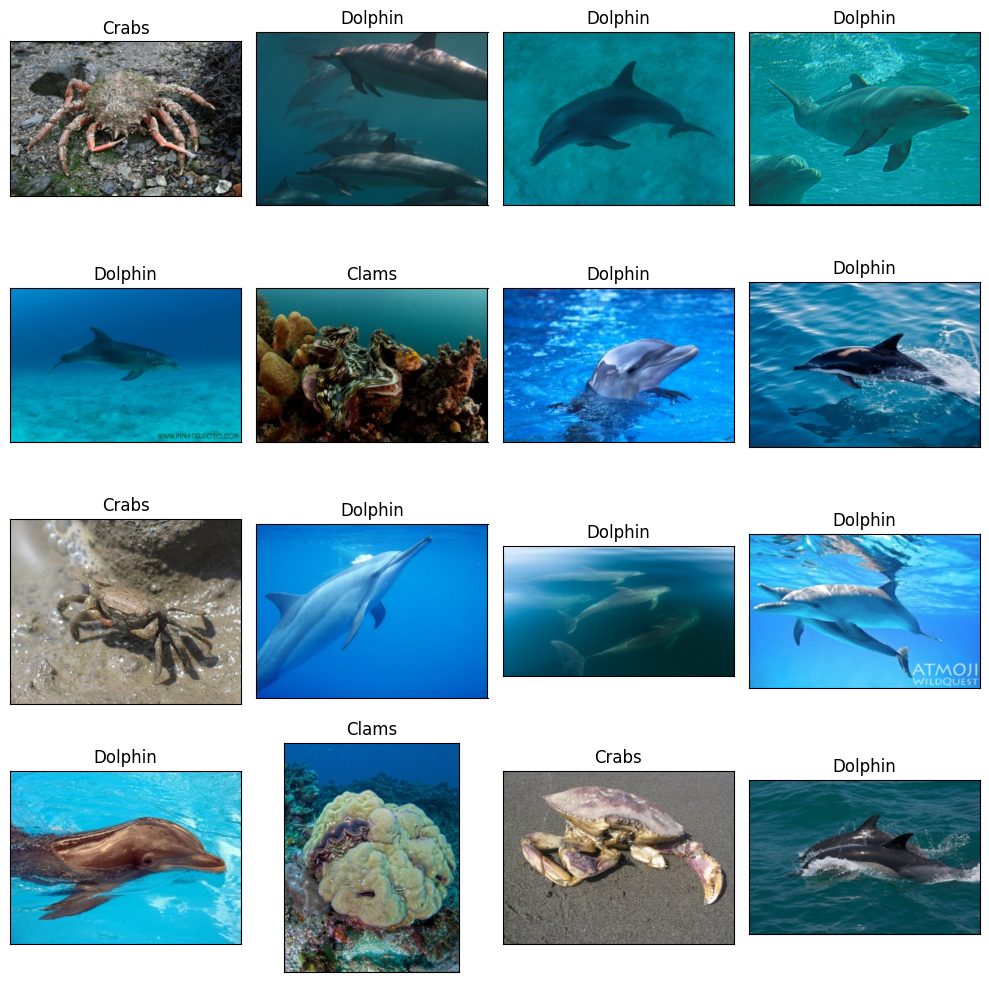

In [12]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,
                                  shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, fill_mode = 'nearest',
    validation_split=0.2) # set validation split

In [14]:
train_images = train_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

validation_images = train_datagen.flow_from_directory(
    data , # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 1424 images belonging to 3 classes.
Found 354 images belonging to 3 classes.


In [15]:
# Load the pretained model
mobile_model = Sequential()

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

mobile_model.add(pretrained_model)

9406464/9406464 [==============================] - 2s 0us/step


In [16]:
mobile_model.add(Flatten())
mobile_model.add(Dense(512, activation='relu'))
mobile_model.add(Dropout(0.2))
mobile_model.add(Dense(3, activation='softmax'))

In [17]:
mobile_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 2915395 (11.12 MB)
Trainable params: 657411 (2.51 MB)
Non-trainable params: 2257984 (8.61 MB)
______________

In [18]:
mobile_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

history = mobile_model.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=10)

Epoch 1/10
45/45 [==============================] - 43s 778ms/step - loss: 0.2995 - accuracy: 0.9164 - val_loss: 0.0633 - val_accuracy: 0.9831
Epoch 2/10
45/45 [==============================] - 29s 645ms/step - loss: 0.0638 - accuracy: 0.9831 - val_loss: 0.0608 - val_accuracy: 0.9802
Epoch 3/10
45/45 [==============================] - 28s 632ms/step - loss: 0.0462 - accuracy: 0.9860 - val_loss: 0.0301 - val_accuracy: 0.9887
Epoch 4/10
45/45 [==============================] - 37s 834ms/step - loss: 0.0560 - accuracy: 0.9810 - val_loss: 0.0197 - val_accuracy: 0.9915
Epoch 5/10
45/45 [==============================] - 29s 647ms/step - loss: 0.0328 - accuracy: 0.9895 - val_loss: 0.0227 - val_accuracy: 0.9887
Epoch 6/10
45/45 [==============================] - 28s 636ms/step - loss: 0.0373 - accuracy: 0.9874 - val_loss: 0.0402 - val_accuracy: 0.9802
Epoch 7/10
45/45 [==============================] - 29s 640ms/step - loss: 0.0370 - accuracy: 0.9867 - val_loss: 0.0142 - val_accuracy: 0.9944

In [19]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


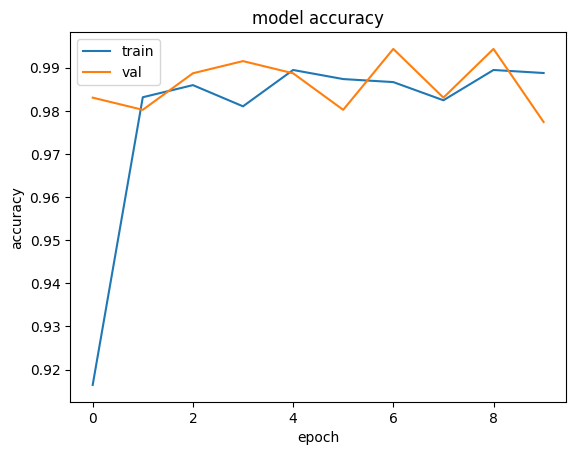

In [20]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

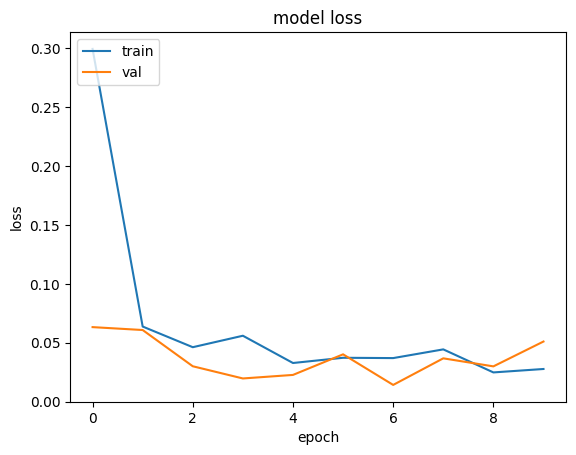

In [21]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
model_save_path = '/content/drive/MyDrive/Трубчик МО/'

# Создаем директорию, если она не существует
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

# Сохраняем модель
mobile_model.save(model_save_path + 'sea_animals_classification_model.h5')

print("Модель успешно сохранена по пути:", model_save_path + 'sea_animals_classification_model.h5')

Модель успешно сохранена по пути: /content/drive/MyDrive/Трубчик МО/sea_animals_classification_model.h5


In [24]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Путь к фотографии, которую вы хотите проверить
test_image_path = "/content/drive/MyDrive/Трубчик МО/Рыбки/Crabs/10010837894_757b671eef_o.jpg"

# Загружаем и предобрабатываем изображение
img = image.load_img(test_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Масштабируем значения пикселей в диапазоне от 0 до 1

# Загружаем сохраненную модель
loaded_model = keras.models.load_model(model_save_path + 'sea_animals_classification_model.h5')

# Получаем предсказания для изображения
predictions = loaded_model.predict(img_array)

# Получаем название класса с наибольшей вероятностью
class_index = np.argmax(predictions)
class_label = train_images.class_indices
class_label = dict((v, k) for k, v in class_label.items())
predicted_class = class_label[class_index]

print("Предсказанный класс:", predicted_class)


1/1 [==============================] - 1s 1s/step
Предсказанный класс: Crabs
